# Iris dataset Analysis with scratched Logistic Regression

## 1. Загрузка и преобразование данных

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

Загрузим датасет и посмотрим на представлениe данных, чтобы преобразовать их в датафрейм.

In [2]:
omg=load_iris()
omg

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

Поскольку нам нужны Versicolor и Virginica, отсекаем первую треть. Дополнительно из названий колонок убираем приписку "cm", говорящую об очевидном.

In [3]:
df = pd.DataFrame(data=np.c_[omg.data, omg.target][50:], columns=([i[:-4] for i in omg['feature_names']]+['target']))
df

sepal length   sepal width   petal length   petal width   target
0             7.0           3.2            4.7           1.4     1.0
1             6.4           3.2            4.5           1.5     1.0
2             6.9           3.1            4.9           1.5     1.0
3             5.5           2.3            4.0           1.3     1.0
4             6.5           2.8            4.6           1.5     1.0
..            ...           ...            ...           ...     ...
95            6.7           3.0            5.2           2.3     2.0
96            6.3           2.5            5.0           1.9     2.0
97            6.5           3.0            5.2           2.0     2.0
98            6.2           3.4            5.4           2.3     2.0
99            5.9           3.0            5.1           1.8     2.0

[100 rows x 5 columns]

Разделим датасет на признаки и целевые переменные. Подготовим данные, разделим их на обучающую и тестовую выборки.

In [4]:
Y = df.target
Y = Y.apply(lambda x: 1 if x == 2.0 else 0)
X = df.iloc[:, [0, 1, 2, 3]]

X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, random_state=100)    

## 2. Реализация модели логистической регрессии

**Напишем класс LogisticRegression, в котором будут два публичных метода - fit и predict. Сразу реализуем все варианты оптимизации обучения, которые мы будем использовать:**
- simple gradient descent;
- RMSProp;
- Nadam - метод Adam, использующий для ускорения метод HAG Nesterov’s Accelerated Gradient

In [5]:
class LogisticRegression:
    """
    Двоичный классификатор на основе логистической регресси.
    """

    def __init__(self,
                 learning_rate=0.01,  # Скорость обучения
                 max_epochs=100,  # Количество эпох
                 random_state=100,
                 method='GD',  # или "RMSP", "Nadam" - метод оптимизации
                 gamma = 0.9,
                 epsilon = 10 ** (-6),
                 beta1 = 0.9,
                 beta2 = 0.999
                 ):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.method = method
        self.gamma = gamma
        self.epsilon = epsilon  # сглаживающий параметр для RSMProp
        self.beta1 = beta1 # параметры алгоритма Nadam
        self.beta2 = beta2

    def __create_start_weight(self, dimension) -> None:
        """
        Инициализация весов в начале обучения.
        dimension --> W = [ w0, w1, w2, w3, w4 ],
        где w0 (OR b) - член смещения
        """

        rgen = np.random.RandomState(self.random_state)
        # Начальные веса и член смещения - в одном векторе
        self.W_ = rgen.normal(loc=0.0, scale=0.01, size=dimension)

    def __extend_X(self, X):
        """
        Функция для добавления фиктивного единичного вектора
        к матрице признаков
        """
        # Будем работать с локальной копией, чтобы не менять исходный датафрейм
        X = X.copy()
        X.insert(0, 'X0', 1)
        return X

    @staticmethod
    def __sigmoid(z):
        """
        Функция логистического отклика (сигмоида). В нашей модели является функцией активации.
        z --> output (OR h(z))
        """
        return 1.0 / (1.0 + np.exp(-z))

    def __net_input(self, X):
        """
        Вычисление общего входа - вектора z с вещественными
        метками
        X, W --> Z
         """
        if self.method == 'Narad' and self.mode_ == 'fit':
            #  Для метода Нестерова реализуем заглядывание вперёд по
            # вектору обновления:
            # рассчитаем градиент не для W, а для  W-gamma*V
            z = np.dot(X, self.W_ - self.V_ * self.gamma)
        else:
            z = np.dot(X, self.W_)
        return z

    def __gradient_descent(self, g):
        """
        Функция обновления весов с использованием градиентного спуска
        X, E --> deltaW =  eta * J(w) = eta * X @ E
        """
        return self.learning_rate * g

    def __RMSProp(self, g):
        """
        Функция обновления весов методом RMSProp
        Возвращает deltaW
        """
        self.E_ = self.gamma * self.E_ + (1 - self.gamma) * g ** 2
        return self.learning_rate * g / (np.sqrt(self.E_+self.epsilon))

    def __Nadam(self, g):
        """
        Функция обновления весов по методу адаптивной оценки
        моментов, ускоренному по Нестерову
        Возвращает deltaW
        """
        b1, b2, e = self.beta1, self.beta2, self.epsilon
        self.m_ = b1 * self.m_ + (1 - b1) * g
        self.V_ = b2 * self.V_ + (1 - b2) * g ** 2
        return self.learning_rate * self.m_ / np.sqrt(self.V_ + e)

    @staticmethod
    def __log_loss(y, h):
        """
        Логарифмическая функция потерь - кросс-энтропия.
        y & h(z) --> J(h(z), y, w)
        """
        # return (- y.dot(np.log(z)) - (1 - y).dot(np.log(1 - z)))
        return - np.sum(y.dot(np.log(h)) + (1 - y).dot(np.log(1 - h)))

    def __build_cost_trace(self, error) -> None:
        """ Функция для подсчёта издержек"""
        self.J_function.append(error)

    def fit(self, X, y):
        """ Функция для обучения модели """

        # Инициируем веса ненулевыми значениями из нормального распределения
        self.__create_start_weight(dimension=X.shape[1] + 1)
        # X.shape - размерность матрицы ( [m, n] )

        # Объявим вектор значений функции потерь (по факту это
        # список с количеством ошибок в каждой итерации)
        self.J_function = []

        # Расширим нашу матрицу признаков на один столбец - единичный вектор.
        # Это упростит расчёт общего входа:
        #                   WT@X+b = (W+b)T@(X+x0) = (W+b)T@X'
        X = self.__extend_X(X)

        # Отключим предупреждение при делении на числа, близкие к нулю
        np.seterr(divide='ignore')

        if self.method == 'Nadam':  # Nesterov-accelerated Adaptive Moment Estimation
            self.V_ = 0
            self.m_ = 0
            update = self.__Nadam
        elif  self.method == 'RMSP':  # Root Mean Square Propagation
            self.E_ = 0
            update = self.__RMSProp
        elif self.method == 'GD':  # Gradient descent
            update = self.__gradient_descent
        else:
            print("Неверно указан метод обновления весов! ")
            return

        # Поскольку при использовании Narad общий вход считается иначе,
        # необходим флаг, помогающий алгоритму использовать особую
        # формулу только при обучении- не во время предсказания
        self.mode_ = 'fit'

        for i in range(self.max_epochs):
            # Перемешиваем наши признаки и метки в начале каждой эпохи
            X = X.sample(frac=1, random_state=self.random_state)
            y = y.sample(frac=1, random_state=self.random_state)
            f = self.__sigmoid(self.__net_input(X))
            error = y - f 
            gradJ = X.T.dot(error)
            self.W_ += update(gradJ)  # delta W
            self.__build_cost_trace(self.__log_loss(y, f))
        print(f'Модель обучена! Метод: {self.method}')

    def predict(self, X):
        """
        Функция для определения метки класса
        X --> Z --> h --> Y'
        """
        # Меняем флажок mode, чтобы при использовании Nadam программа
        # не пыталась использовать особую формулу подсчёта градиента.
        self.mode_ = 'predict'
        
        # Здесь тоже нужно добавить в матрицу фиктивный столбец
        X = self.__extend_X(X)
        return np.where(self.__sigmoid(self.__net_input(X)) >= 0.5, 1, 0)

Чтобы обучить модель определённым образом, нужно выбрать соответсвующий алгоритм при создании модели

## 3. Метрики

Мы используем простой датасет, в котором различных меток поровну и нет задачи "поймать" редкие, аномальные значения. Найти процент правильно классифицированных образцов - отличный вариант для анализа точности модели. Так же мы сравним поведение функций издержек.

In [6]:
def check_scores(pred, target):
    scores = 0
    for check, true in zip(pred, target):
        if float(check) == true:
            scores +=1
    return f'{scores/len(target)*100}%'

## 4. Обучение модели

Обучим три разные модели. Используем одинаковые скорость обучения и количество эпох, чтобы сопоставить работу алгоритмов. За счёт этого мы так же сможем сравнить минимальное значение функции издержек. 
Специально возьмём большое количество эпох.

1) Простой градиентный спуск

In [7]:
GD_model = LogisticRegression(learning_rate=0.0095, max_epochs=2000, method='GD')
GD_model.fit(X_train, Y_train)

Модель обучена! Метод: GD


Получим результат

In [8]:
GD_Y_pred = GD_model.predict(X)
# Полученные метки перемешаны, поэтому отсортируем их.
GD_Y_pred.sort()
GD_Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

2) Root Mean Square Propagation

In [9]:
RMSP_model = LogisticRegression(learning_rate=0.0095, max_epochs=2000, method='RMSP')
RMSP_model.fit(X_train, Y_train)

Модель обучена! Метод: RMSP


In [10]:
RMSP_Y_pred = RMSP_model.predict(X)
RMSP_Y_pred.sort()

3) Nesterov–accelerated Adaptive Moment Estimation

In [11]:
Nadam_model = LogisticRegression(learning_rate=0.0095, max_epochs=2000, method='Nadam', gamma=0.8)
Nadam_model.fit(X_train, Y_train)

Модель обучена! Метод: Nadam


In [12]:
Nadam_Y_pred = Nadam_model.predict(X)
Nadam_Y_pred.sort()

## 5. Анализ результатов

#### Посмотрим на графики кривых издержек

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

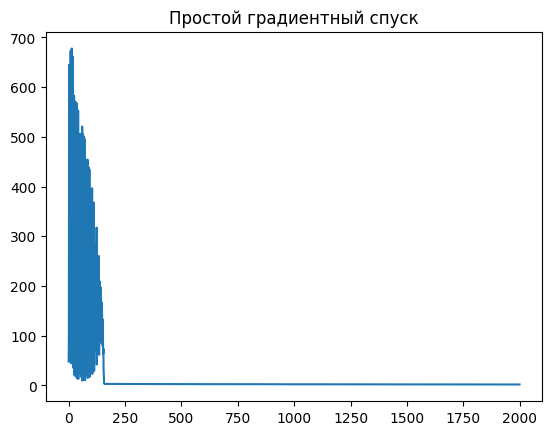

In [14]:
plt.plot(GD_model.J_function)
plt.title("Простой градиентный спуск")
 
plt.show()

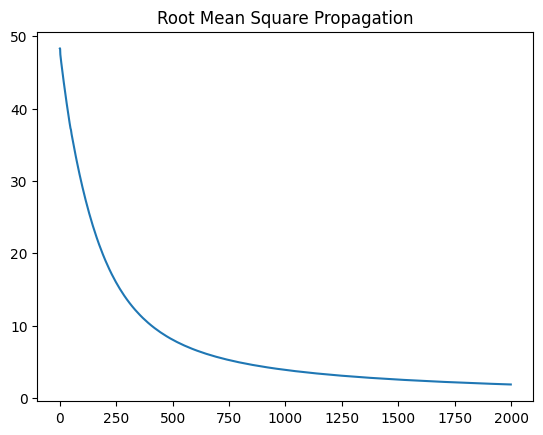

In [15]:
plt.plot(RMSP_model.J_function)
plt.title("Root Mean Square Propagation")
plt.show()

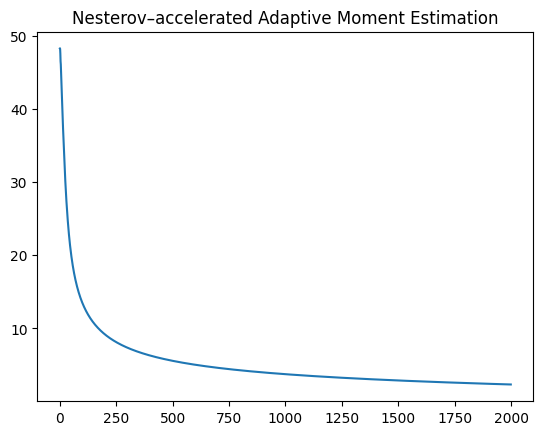

In [16]:
plt.plot(Nadam_model.J_function)
plt.title("Nesterov–accelerated Adaptive Moment Estimation")
plt.show()

#### Определим точность каждого алгоритма. Сформируем списки с точностью и минимальным значением функции потерь

In [17]:
predictions = (GD_Y_pred, RMSP_Y_pred, Nadam_Y_pred)
models = (GD_model, RMSP_model, Nadam_model)
accuracy = []
J_list = []
for y, m in zip(predictions, models):
    accuracy.append(check_scores(y, target=Y))
    J_list.append(min(m.J_function))

In [18]:
result = {'Method': 
          ['GD', 'RMSP', 'Nadam'], 
          'accuracy': accuracy,
          # [check_scores(y, target=Y) for y in (GD_Y_pred, RMSP_Y_pred, Nadam_Y_pred)]
         'min J': J_list,
         }

In [19]:
res = pd.DataFrame(result)
res.set_index('Method', inplace=True)
res

accuracy     min J
Method                   
GD        97.0%  2.054259
RMSP      99.0%  1.879123
Nadam     97.0%  2.320643

## 6. Вывод

**Логистическая регрессия успешно справляется с ирисами при использовании любого алгоритма оптимизации. 
Простой градиентный спуск сходится очень быстро (достаточно 250 итераций для точности 96%). Усовершенствованные алгоритмы более устойчивы. RMSM самый медленный, но даёт самую большую точность - 99%. Максимальная точность, которую удалось получить для GD и Nadam - 97%. Чем ближе функция потерь приближается к нулю, тем точнее модель.**

Напоследок - вариант модели, дающий не самую высокую точность, но самый красивый график

Модель обучена! Метод: GD


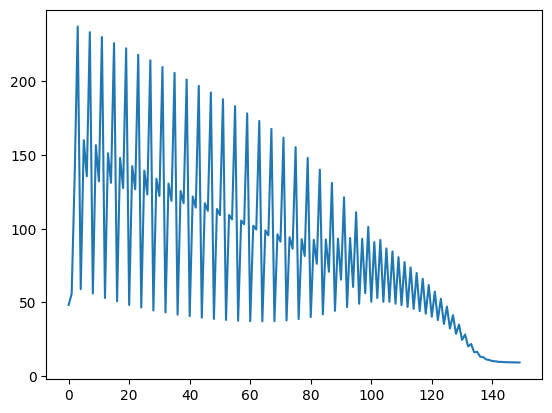

In [20]:
GD_model = LogisticRegression(learning_rate=0.004, max_epochs=150, method='GD')
GD_model.fit(X_train, Y_train)
plt.plot(GD_model.J_function)
plt.show()